In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub  # Movinet 모델을 불러오기 위한 tensorflow_hub 모듈 임포트
import matplotlib.pyplot as plt  # 시각화를 위한 matplotlib 임포트

2024-08-26 00:22:05.940020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 00:22:06.431409: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-26 00:22:08.408114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda

In [2]:
# 프레임을 중앙 정사각형으로 자르는 함수
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim, start_x:start_x+min_dim]

# 로컬 디스크에서 비디오를 로드하는 함수
def load_video_from_local(local_path, max_frames=64, resize=(224, 224)):
    cap = cv2.VideoCapture(local_path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # BGR에서 RGB로 변환
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    
    return np.array(frames)

# 하위 디렉토리까지 재귀적으로 탐색하여 로컬 디렉토리에서 모든 .mp4 파일을 찾는 함수
def find_all_videos_in_local_directory(directory):
    video_files = []
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp4'):
                video_files.append(os.path.join(root, file))
    
    return video_files

# 모든 비디오를 로컬 디스크에서 로드
def prepare_data_from_local(local_data_dir, max_frames=64, resize=(224, 224), max_videos_per_class=350):
    videos = []
    labels = []
    total_videos_loaded = 0

    class_names = [d for d in os.listdir(local_data_dir) if os.path.isdir(os.path.join(local_data_dir, d))]
    class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(local_data_dir, class_name)
        
        video_files = find_all_videos_in_local_directory(class_path)
        
        video_count = 0
        
        for video_file in video_files:
            if video_count >= max_videos_per_class:
                break
            
            video_frames = load_video_from_local(video_file, max_frames=max_frames, resize=resize)
            if video_frames is not None and len(video_frames) == max_frames:
                videos.append(video_frames)
                labels.append(class_to_label[class_name])
                video_count += 1
                total_videos_loaded += 1  # 동영상 로드 개수 증가
    
    print(f'Total videos loaded: {total_videos_loaded}')
    return np.array(videos), np.array(labels), class_names, total_videos_loaded

# 데이터 증강 함수
def augment_frame(frame):
    frame = tf.image.random_flip_left_right(frame)
    frame = tf.image.random_brightness(frame, max_delta=0.2)
    frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
    frame = tf.image.random_saturation(frame, lower=0.8, upper=1.2)
    frame = tf.image.random_hue(frame, max_delta=0.05)  # 추가: 색조 변환
    frame = tf.image.random_crop(frame, size=[200, 200, 3])  # 추가: 랜덤 크롭
    frame = tf.image.resize(frame, [224, 224])  # 크롭 후 리사이즈
    return frame


# 전처리 및 증강 함수
def preprocess_and_augment(video, label, augment=False):
    video = tf.image.resize(video, [224, 224])
    
    if augment:
        video = tf.map_fn(augment_frame, video)
    
    video = tf.cast(video, tf.float32) / 255.0
    return video, label

# tf.data.Dataset을 사용하여 데이터 준비
def create_dataset(X, y, batch_size=32, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(lambda x, y: preprocess_and_augment(x, y, augment=augment),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Movinet 모델을 사용하여 학습을 위한 함수
def build_movinet_model(input_shape, num_classes, trainable=True):
    # Movinet A2 모델 불러오기
    movinet_model = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/movinet/a2/base/kinetics-600/classification/3", 
        trainable=trainable  # 전체 모델의 훈련 가능 여부 설정
    )
    
    inputs = layers.Input(shape=input_shape)
    movinet_inputs = {'image': inputs}
    x = movinet_model(movinet_inputs)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)

    # Adam 옵티마이저와 가중치 감쇠를 사용하여 모델 컴파일
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=1e-4,
        first_decay_steps=10000,
        t_mul=2.0,
        m_mul=0.9,
        alpha=0.0
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    
    # 가중치 감쇠를 위해 전체 모델의 가중치에 대한 정규화 추가
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
    )

    return model

# 학습 결과 시각화 함수
def plot_training_history(history):
    # 정확도 시각화
    plt.figure(figsize=(12, 4))
    
    # 학습 정확도와 검증 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Over Epochs')
    
    # 학습 손실과 검증 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss Over Epochs')
    
    plt.show()

In [3]:
# 로컬 디스크에서 데이터 로드
local_data_dir = 'data/local_videos'
X, y, class_names, total_videos_loaded = prepare_data_from_local(local_data_dir, max_videos_per_class=340)

Total videos loaded: 846


In [4]:
# 데이터를 훈련과 검증 세트로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# tf.data.Dataset 객체 생성 및 증강 적용
train_dataset = create_dataset(X_train, y_train, batch_size=4, augment=True)
val_dataset = create_dataset(X_val, y_val, batch_size=4, augment=False)

2024-08-26 00:25:24.697895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 00:25:25.014331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
# 1차 학습: 상위 10개의 레이어만 훈련 가능하게 설정
input_shape = (64, 224, 224, 3)
num_classes = len(class_names)
model = build_movinet_model(input_shape, num_classes, trainable=False)

# 모델 요약 출력
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 224, 224, 3)  0         
                             ]                                   
                                                                 
 keras_layer (KerasLayer)    (None, 600)               5280922   
                                                                 
 dense (Dense)               (None, 5)                 3005      
                                                                 
Total params: 5,283,927
Trainable params: 3,005
Non-trainable params: 5,280,922
_________________________________________________________________


In [7]:
# 체크포인트 콜백 설정
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'movinet_model_checkpoint_initial.h5', 
    save_best_only=True, 
    save_weights_only=True
)

# 조기 종료 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# 1차 학습 (대부분의 레이어 동결)
model = build_movinet_model(input_shape, num_classes, trainable=False)  # 대부분의 레이어 동결
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[checkpoint, early_stopping])

# 1차 학습 모델 저장
model.save('model/initial_movinet_dog_action_recognition_model_2.h5')

Epoch 1/30


2024-08-26 00:26:30.731055: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x557cedf28620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-26 00:26:30.731128: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-08-26 00:26:30.921599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2024-08-26 00:26:32.432498: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-26 00:26:45.047723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-26 00:26:45.106710: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` 

169/169 [==============================] - 76s 262ms/step - loss: 2.0551 - accuracy: 0.2870 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.0089 - val_accuracy: 0.2588 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/30
169/169 [==============================] - 27s 159ms/step - loss: 1.7251 - accuracy: 0.3521 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.8521 - val_accuracy: 0.2706 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/30
169/169 [==============================] - 27s 159ms/step - loss: 1.4972 - accuracy: 0.4068 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.7304 - val_accuracy: 0.3353 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/30
169/169 [==============================] - 27s 159ms/step - loss: 1.3800 - accuracy: 0.4467 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.6537 - val_accuracy: 0.3765 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/30
169/169 [==============================] - 27s 159ms/step - loss: 1.2685 - accuracy: 0.4867 - top_k_categori

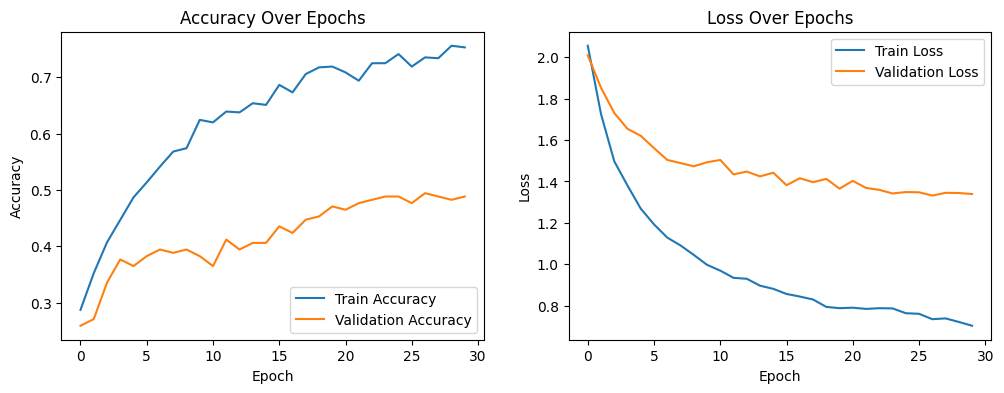

In [8]:
plot_training_history(history)

In [9]:
# 이전에 저장한 1차 모델 불러오기
model = tf.keras.models.load_model('model/initial_movinet_dog_action_recognition_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# 모든 레이어를 훈련 가능하게 설정
for layer in model.layers:
    layer.trainable = True

# 학습률을 줄여서 모델을 다시 컴파일
initial_learning_rate = 1e-5  # 더 작은 학습률로 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

# 2차 학습용 체크포인트 콜백 설정
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'movinet_model_checkpoint_finetune.h5', 
    save_best_only=True, 
    save_weights_only=True
)

# 2차 학습
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[checkpoint, early_stopping])

# 최종 모델 저장
model.save('model/final_movinet_dog_action_recognition_model_2.h5')


Epoch 1/30
169/169 [==============================] - 165s 501ms/step - loss: 1.3078 - accuracy: 0.4334 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.0629 - val_accuracy: 0.5706 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/30
169/169 [==============================] - 73s 433ms/step - loss: 1.1796 - accuracy: 0.5044 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.0657 - val_accuracy: 0.5882 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/30
169/169 [==============================] - 74s 437ms/step - loss: 1.0681 - accuracy: 0.5843 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.0389 - val_accuracy: 0.5647 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/30
169/169 [==============================] - 74s 436ms/step - loss: 0.9970 - accuracy: 0.6213 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9727 - val_accuracy: 0.6118 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/30
169/169 [==============================] - 74s 436ms/step - loss: 0.9084 - accuracy: 0.6686 - to

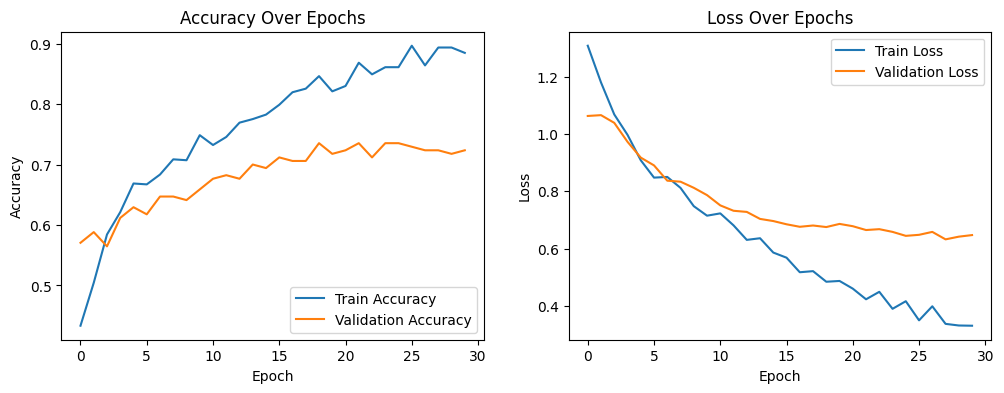

In [10]:
plot_training_history(history)

In [ ]:
# 로컬 비디오 파일에서 비디오를 읽어오는 함수
def load_video(video_path, max_frames=64, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # BGR에서 RGB로 변환
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    
    return np.array(frames) / 255.0

# 예측 함수 수정 후 다시 정의
def predict_action(video_path, model, class_names, max_frames=64, resize=(224, 224)):
    video = load_video(video_path, max_frames=max_frames, resize=resize)
    
    if len(video) < max_frames:
        raise ValueError(f"영상의 프레임이 충분하지 않습니다. (필요한 프레임: {max_frames}, 실제 프레임: {len(video)})")

    video = np.expand_dims(video, axis=0)  # 배치 차원 추가
    predictions = model.predict(video)
    
    # 각 클래스의 확률을 출력
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i] * 100:.2f}%")

    predicted_class = np.argmax(predictions)
    print(f"\nPredicted action: {class_names[predicted_class]} ({predictions[0][predicted_class] * 100:.2f}%)")

# 예측 사용 예시
video_path = "backup_BODYSCRATCH_BODYSCRATCH5.mp4"  # 테스트할 비디오 경로
predict_action(video_path, model, class_names)